In [1]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm

import sys
sys.path.append("../scripts")

In [23]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [24]:
def plot_fcst(fcst, train=None, test=None):
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [25]:
def get_forecastables(df, T=0.5):
    amount_info = df.notna().sum() / len(df)
    forecastable = (amount_info > T)
    return df.loc[:, forecastable].copy()

In [26]:
def get_amount_info(df):
    amount_info = df.notna().sum() / len(df)
    return amount_info

In [27]:
plt.rcParams["figure.figsize"] = (14,4)

In [28]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [29]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Forecast por producto

In [30]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [31]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


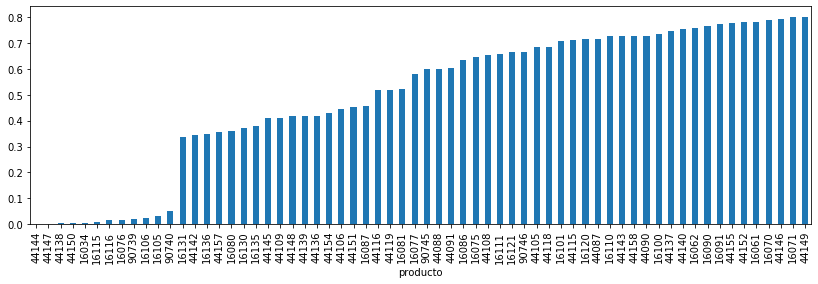

In [32]:
amount_info = get_amount_info(u_producto)
amount_info.sort_values().plot(kind="bar")

In [33]:
u_producto_forecastable = get_forecastables(u_producto, T=0.5)

In [34]:
idx = pd.date_range('2017-01-01', '2019-12-31')
u_producto_forecastable = u_producto_forecastable.reindex(index=idx)

In [35]:
train, test = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

In [36]:
train.head()

producto,16061,16062,16070,16071,16075,16077,16081,16086,16090,16091,...,44137,44140,44143,44146,44149,44152,44155,44158,90745,90746
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,7.0,1.0,25.0,11.0,3.0,NaN,1.0,NaN,17.0,6.0,...,1.0,1.0,1.0,8.0,14.0,NaN,1.0,NaN,NaN,NaN
2017-01-03,21.0,NaN,27.0,2.0,NaN,NaN,NaN,4.0,21.0,1.0,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,8.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,4.0,2.0,NaN,1.0,1.0,NaN,NaN
2017-01-05,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,5.0,5.0,...,2.0,3.0,3.0,15.0,16.0,NaN,10.0,1.0,NaN,NaN


In [37]:
item_id = 16070
y_train = train[item_id].interpolate().bfill()
y_test = test[item_id].interpolate().bfill()

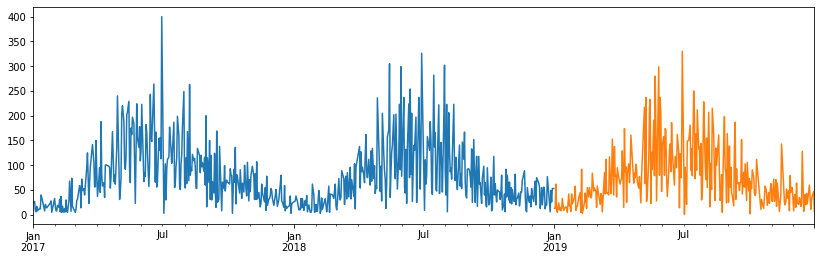

In [38]:
y_train.plot()
y_test.plot()

In [39]:
y_train_boxcox, lmbda = boxcox(y_train)
y_train_boxcox = pd.Series(y_train_boxcox, index=y_train.index)

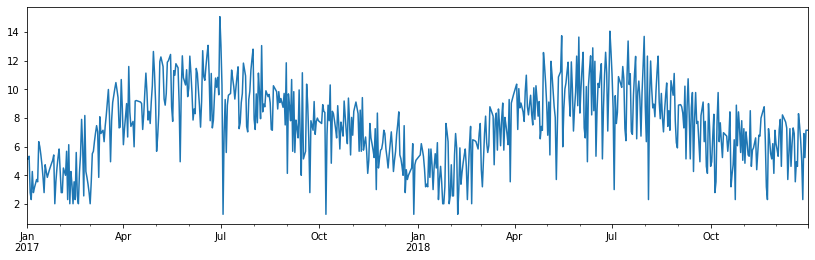

In [40]:
y_train_boxcox.plot()

In [41]:
from tbats import BATS, TBATS

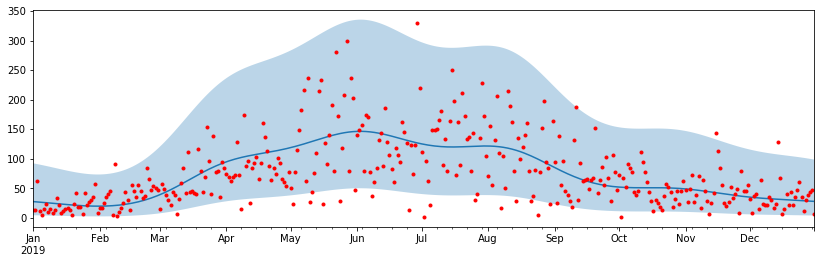

In [42]:
estimator = TBATS(use_box_cox=False, use_trend=False, use_damped_trend=False, seasonal_periods=[365.25])
model = estimator.fit(y_train_boxcox)
fcst = model.forecast(steps=365, confidence_level=0.95)
fcst = pd.DataFrame(fcst[1])
fcst = fcst.rename(columns={"mean":"yhat", "lower_bound":"yhat_lower", "upper_bound":"yhat_upper"})
fcst = fcst.drop(columns="calculated_for_level", errors="ignore")
fcst.index = test.index
fcst = inv_boxcox(fcst, lmbda)
plot_fcst(fcst, test=y_test)

Text(0.5, 0, '')

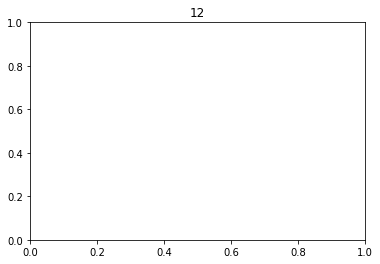

In [7]:
f, ax = plt.subplots(1,1)
ax.set_title(12)
ax.set_xlabel("")

In [ ]:
ax.set_xlabel